# Desafío - Análisis Lineal Discriminante 
____

Nombre: __Hugo Zúñiga__

Profesor: Josué Fredes

Generación: __G4__

* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad. 
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv). 
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección correspondiente.

## Descripción

Trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se registran las siguientes observaciones:

* `default`: Variable Binaria. Registra si el cliente entró en morosidad o no.
* `income`: Ingreso promedio declarado por el cliente.
* `balance`: Total del sando en la cuenta de crédito.
* `student`: Variable binaria. Registra si el cliente es estudiante o no.

## Ejercicio 1: Preparación de ambiente de trabajo

* Importe los módulos básicos para el análisis de datos.
* Importe las clases `LabelEncoder`, `StandardScaler` y `LabelBinarizer` de `preprocessing`
* Importe las funciones `train_test_split` y `cross_val_score` de `model_selection`
* Importe la función `classification_report` de `metrics`
* Importe las clases `LinearDiscriminantAnalysis` y `QuadraticDiscriminantAnalysis`.
* Agregue la base de datos en el ambiente de trabajo.
* Inspeccione la distribución de cada atributo

In [2]:
# Importo los básico
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importo clases y funciones
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Para gráficos y visualización
import warnings
warnings.simplefilter('ignore')
from matplotlib.colors import LinearSegmentedColormap
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn')

In [3]:
# Importo la base
df = pd.read_csv('default_credit.csv').drop(columns='index')
df.head()

default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879

In [4]:
# Inspeccionamos la bbdd
df.describe()

balance        income
count  10000.000000  10000.000000
mean     835.374886  33516.981876
std      483.714985  13336.639563
min        0.000000    771.967729
25%      481.731105  21340.462903
50%      823.636973  34552.644802
75%     1166.308386  43807.729272
max     2654.322576  73554.233495

__Comentario:__ Con esto se comprueba que existen dos variables continuas.

In [5]:
# Revisamos los tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
default    10000 non-null object
student    10000 non-null object
balance    10000 non-null float64
income     10000 non-null float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


__Comentario:__ Acá también se ve, dado que dos son de tipo _object_ y dos de tipo _float64_. Revisaremos la distribución y las frecuencias de cada tipo de variable respectivamente.

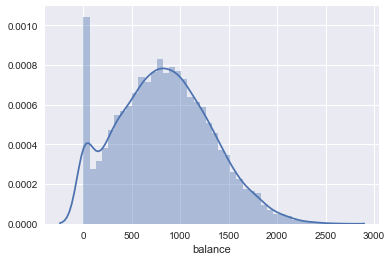

In [6]:
# Reviso distribución de las variables continuas
sns.distplot(df['balance'])

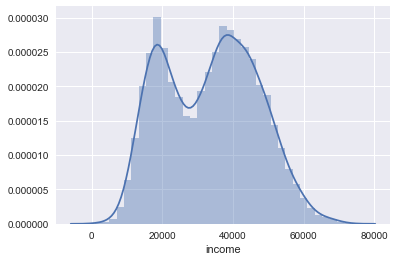

In [7]:
sns.distplot(df['income'])

__Comentario:__ Se puede observar que en ambas existen dos _picks_: en _balance_ se encuentra en el $0$ y otro cercano a $700$ y en _income_ uno en $20000$ y otro cercano a $40000$.

No     0.9667
Yes    0.0333
Name: default, dtype: float64


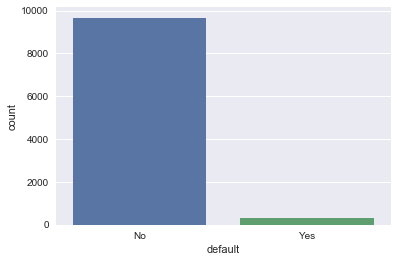

In [8]:
# Reviso las frecuencias de default y student
sns.countplot(df['default'])
print(df['default'].value_counts('%'))

No     0.7056
Yes    0.2944
Name: student, dtype: float64


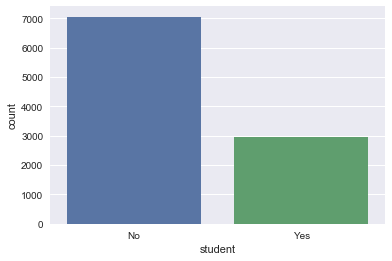

In [9]:
sns.countplot(df['student'])
print(df['student'].value_counts('%'))

__Comentario:__ Se puede observar que la tendencia a tener morosidad es bastante baja, apenas $.03$. Así mismo, se ve que la mayoría de los clientes no son estudiantes.

## Ejercicio 2: Modelo base

* Recuerde que los modelos de `sklearn` no soportan datos que no sean numéricos. Transforme los atributos pertinentes con `LabelEncoder`
* Genere muestras de validación y entrenamiento, reservando un 33% de los datos como validación.
* Genere un modelo con `LinearDiscriminantAnalysis` sin modificar los hiperparámetros. Genere métricas de evaluación utilizando `classification_report`.
* Comente sobre cuál es el desempeño del modelo en cada clase, así como en general.

In [10]:
# Aplico LabelEncoder para default y student
df['default'] = LabelEncoder().fit_transform(df['default'])
df['default'].sample(10)

6644    0
4576    0
245     0
1062    0
5247    0
9663    0
7714    0
6344    0
4593    0
5343    0
Name: default, dtype: int64

In [11]:
df['student'] = LabelEncoder().fit_transform(df['student'])
df['student'].sample(10)

2364    0
4560    0
6681    0
6311    0
1102    0
1130    1
81      0
6284    1
8794    0
2027    0
Name: student, dtype: int64

In [12]:
df.sample(10)

default  student      balance        income
8321        0        1   521.841479  10316.336741
2056        0        1   793.562784  13446.056291
6923        1        1  1233.445895  12586.478191
1874        0        0   168.813495  57262.754505
8757        0        1  1486.377300  19164.350400
7285        0        0   737.176958  54160.857890
8100        0        0   488.566319  25407.215917
1880        0        0   572.166139  43807.219046
6791        0        1   995.039430   8750.558800
6281        0        0   688.022470  29019.817888

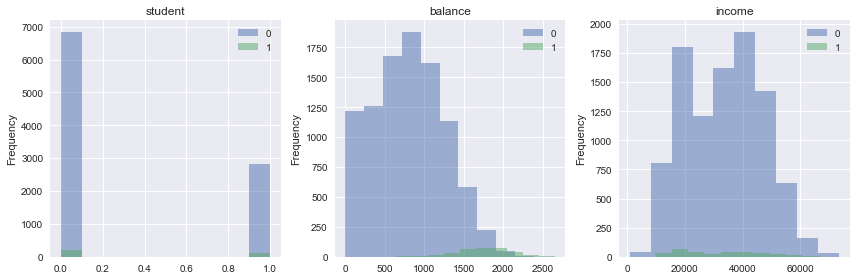

In [13]:
# Valido como se comportan income y balance respecto a default
plt.figure(figsize=(12, 4))
for n, i in enumerate(df.drop(columns = 'default').columns):
    plt.subplot(1, 3, n + 1)
    df.groupby('default')[i].plot(kind='hist', alpha=.5)
    plt.legend(df['default'].unique())
    plt.title(i)
    plt.tight_layout()

__Comentario:__ Se observa la diferencia entre moroso y no moroso en cada variable.

In [14]:
# Genero las muestras de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,'student':'income'],
                                                    df['default'], 
                                                    test_size=.33, 
                                                    random_state=16254)

In [15]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [16]:
# Genero el vector predicho
y_hat = lda_model.predict(X_test)

In [17]:
# Utilizo esta función que me permite ver las métricas de desempeño por clase
def plot_class_report(y_test, y_hat, classes_labels, graph=1):
    """
    Retorna las métricas de desempeño por cada clase.

    """
    tmp_report = classification_report(y_test, y_hat, output_dict=True)
    targets = list(classes_labels)
    targets.append('average')
    tmp_report = pd.DataFrame(tmp_report).drop(columns=['weighted avg', 'macro avg'])
    tmp_report.columns = targets
    tmp_report = tmp_report.drop(labels='support')
    tmp_report = tmp_report.drop(columns='average')
    tmp_report = tmp_report.T
    
    if graph==1:
        for index, (colname, serie) in enumerate(tmp_report.iteritems()):
            plt.subplot(len(targets), 1, index + 1)
            serie.plot(kind = 'barh')
            plt.title(f"Métrica: {colname}")
            plt.tight_layout()
    else:
        return tmp_report

In [18]:
# Utilizo esta función que me permite ver la matriz de confusión
def plot_confusion_matrix(y_test, y_hat, classes_labels):
    """
    Muestra la matriz de confusión por clase.

    """
    color_palette_divergent = LinearSegmentedColormap.from_list('ee', ['#E27872', '#F9F9F8', '#509A9A'])
    color_palette_discrete = ['#4477AA', '#66CCEE', '#228833', '#CCBB44', '#EE6677', '#AA3377', '#BBBBBB']
    color_palette_sequential = [ '#ece3f0', '#d0d1e6', '#a6bddb', '#67a9cf', '#3690c0', '#02818a', '#016c59', '#014636']
    
    tmp_confused = confusion_matrix(y_test, y_hat)
    custom_cmap = LinearSegmentedColormap.from_list('lista', color_palette_sequential)
    sns.heatmap(tmp_confused, annot=True, cbar=False, cmap=custom_cmap, xticklabels=classes_labels,
                yticklabels=classes_labels)
    plt.xlabel('Classes on testing data')
    plt.ylabel('Predicted classes on training')
    plt.grid(False)

In [19]:
print("Probabilidades a priori\n", lda_model.priors_, "\n")
print("Medias de atributos en cada clase\n",
      lda_model.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n",
      lda_model.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.96626866 0.03373134] 

Medias de atributos en cada clase
 [[2.900000e-01 8.044200e+02 3.347329e+04]
 [3.900000e-01 1.765140e+03 3.194734e+04]] 

Varianza explicada por cada discriminante
 [1.] 



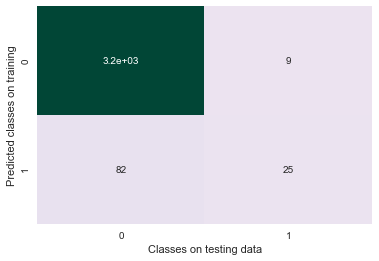

In [20]:
plot_confusion_matrix(y_test, y_hat, df['default'].unique())

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3193
           1       0.74      0.23      0.35       107

    accuracy                           0.97      3300
   macro avg       0.86      0.62      0.67      3300
weighted avg       0.97      0.97      0.97      3300



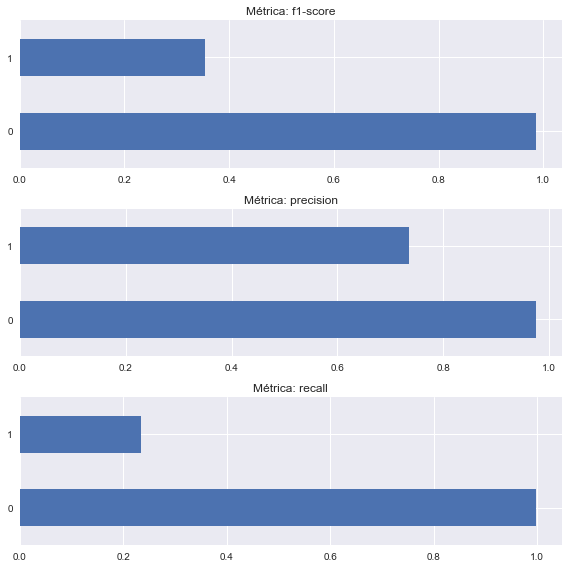

In [21]:
# Muestro las métricas de desempeño en general
print(classification_report(y_test, y_hat))
# Muestro las métricas de desempeño por clase
plt.figure(figsize=(8, 8))
plot_class_report(y_test, y_hat, classes_labels=df['default'].unique())

__Comentario:__ El objetivo es determinar si un cliente es moroso. En este caso podemos considerar Precision como una buena métrica, la que nos dice que el modelo tiene una capacidad del 74% en predecir cuando un cliente es moroso. Esto además considerando que a priori, el $0,03%$ de los clientes tienen morosidad.

## Ejercicio 3: Refactorización 1 - información a priori

* Dado que trabajamos con modelos generativos, podemos incluír información exógena. Para este caso agregaremos dos distribuciones:
    * Asumamos que hay un 50/50 de morosos y no morosos.
    * Asumamos que hay un 60/40 de morosos y no morosos.
* Por cada modelo, reporte las métricas de clasificación.

In [22]:
# Refactorizamos asumiendo que los morosos y no morosos son 50/50
priors = [.5, .5]
lda_model_pr_1 = LinearDiscriminantAnalysis(priors=priors)
lda_model_pr_1.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=[0.5, 0.5], shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [23]:
# Genero el vector predicho
y_hat_pr_1 = lda_model_pr_1.predict(X_test)

In [24]:
print("Probabilidades a priori\n", lda_model_pr_1.priors_, "\n")
print("Medias de atributos en cada clase\n", lda_model_pr_1.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", lda_model_pr_1.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.5 0.5] 

Medias de atributos en cada clase
 [[2.900000e-01 8.044200e+02 3.347329e+04]
 [3.900000e-01 1.765140e+03 3.194734e+04]] 

Varianza explicada por cada discriminante
 [1.] 



              precision    recall  f1-score   support

           0       1.00      0.85      0.92      3193
           1       0.16      0.88      0.28       107

    accuracy                           0.85      3300
   macro avg       0.58      0.86      0.60      3300
weighted avg       0.97      0.85      0.90      3300



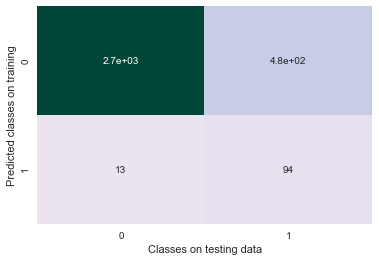

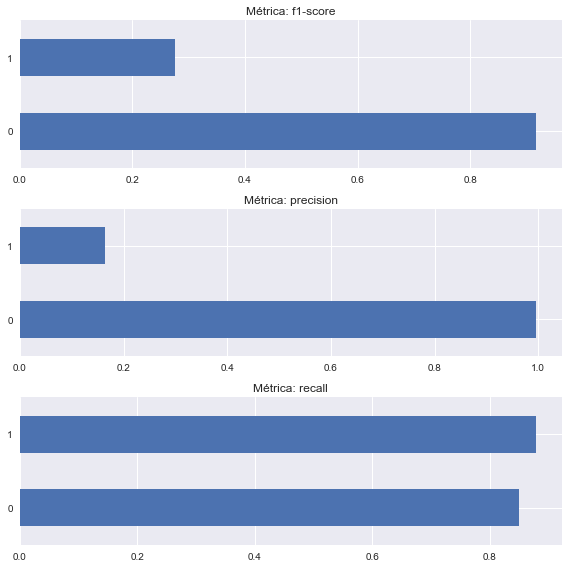

In [25]:
# Confusion matrix
plot_confusion_matrix(y_test, y_hat_pr_1, df['default'].unique())
# Muestro las métricas de desempeño en general
print(classification_report(y_test, y_hat_pr_1))
# Muestro las métricas de desempeño por clase
plt.figure(figsize=(8, 8))
plot_class_report(y_test, y_hat_pr_1, classes_labels=df['default'].unique())

__Comentario:__ Considerando _presicion_ el modelo baja sustancialmente de rendimiento. Sin embargo, _recall_ presenta una gran mejora dado lo bajo de los Falsos Negativos.

In [26]:
# Refactorizamos asumiendo que los morosos y no morosos son 40/60
priors_2 = [.4, .6]
lda_model_pr_2 = LinearDiscriminantAnalysis(priors=priors_2)
lda_model_pr_2.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=[0.4, 0.6], shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [27]:
lda_model.classes_

array([0, 1])

In [28]:
# Genero el vector predicho
y_hat_pr_2 = lda_model_pr_2.predict(X_test)

In [29]:
print("Probabilidades a priori\n", lda_model_pr_2.priors_, "\n")
print("Medias de atributos en cada clase\n", lda_model_pr_2.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", lda_model_pr_2.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.4 0.6] 

Medias de atributos en cada clase
 [[2.900000e-01 8.044200e+02 3.347329e+04]
 [3.900000e-01 1.765140e+03 3.194734e+04]] 

Varianza explicada por cada discriminante
 [1.] 



              precision    recall  f1-score   support

           0       1.00      0.80      0.88      3193
           1       0.13      0.90      0.22       107

    accuracy                           0.80      3300
   macro avg       0.56      0.85      0.55      3300
weighted avg       0.97      0.80      0.86      3300



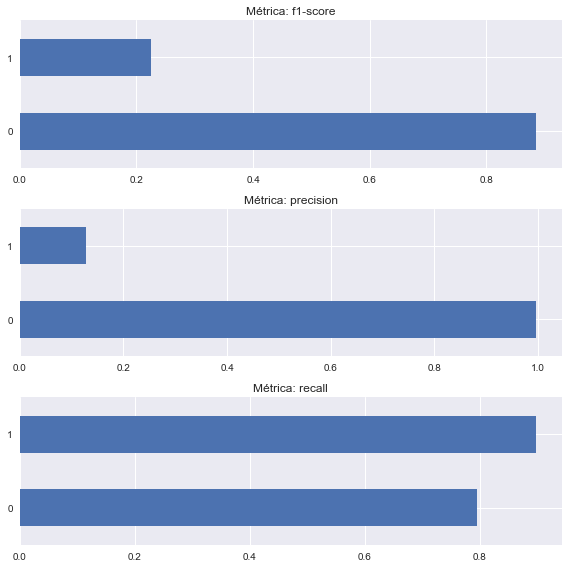

In [30]:
# Muestro las métricas de desempeño en general
print(classification_report(y_test, y_hat_pr_2))
# Muestro las métricas de desempeño por clase
plt.figure(figsize=(8, 8))
plot_class_report(y_test, y_hat_pr_2, classes_labels=df['default'].unique())

__Comentario:__ Acá también vemos que mejora _recall_ sin embargo _precision_ sigue siendo muy bajo respecto al primero modelo.

## Ejercicio 4: Refactorización 2 - oversampling

Digresión: Synthetic Over(Under)Sampling

* Por lo general podemos intentar aliviar el problema del desbalance de clases mediante la ponderación dentro del algoritmo. Otra alternativa es el muestreo con reemplazo dentro de los conjuntos de entrenamiento. Estos métodos clásicos se conocen como Oversampling cuando repetimos registros aleatorios de la clase minoritaria, y Undersampling cuando eliminamos aleatoriamente registros de la clase mayoritaria.
* Un contratiempo de estos métodos clásicos es que pueden replicar información sesgada que afecte el desempeño de generalización del modelo. Si los datos son malos, estaremos replicando estas fallas.
* Otra solución es generar ejemplos de entrenamiento sintéticos mediante el entrenamiento de ejemplos de la clase minoritaria. A grandes rasgos la solución funciona de la siguiente forma: En función a un subconjunto de datos correspondientes a la case minoritaria, entrenamos algún modelo no supervisado o generativo como Naive Bayes, KMeans o KNearestNeighbors para generar representaciones sintéticas de los datos en el espacio de atributos de la clase específica mediante $\mathbf{x}{\textsf{nuevo-ejemplo}} = \mathbf{x}{i} + \lambda (\mathbf{x}{zi} - \mathbf{x}{i})$ donde $\mathbf{x}_{zi}$ es un ejemplo de entrenamiento de la clase minoritaria y $\lambda$ es un parámetro de interpolación aleatorio $\lambda \sim \textsf{Uniforme}(0, 1)$.

* Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre clases. Ahora generaremos observaciones sintéticas mediante __SMOTE__ (Synthetic Minority Oversampling Technique). Para ello, debemos agregar el paquete a nuestro ambiente virtual. En nuestro terminal agregamos `conda install -c conda-forge imbalanced-learn`. Incorpore SMOTE en el ambiente de trabajo con la siguiente sintáxis `from imblearn.over_sampling import SMOTE`.

* Para implementar oversampling, debemos generar nuevos objetos que representan nuestra muestra de entrenamiento incrementada artificialmente. Para ello implemente la siguiente sintáxis:

```python
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=11238, ratio='minority')
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)
```

* Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente sobre su desempeño.

In [31]:
# Aplicamos oversampler
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=16254, ratio='minority')
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)

In [32]:
# Refactorizamos el modelo utilizando los vectores incrementados artificialmente
lda_model_oversamp = LinearDiscriminantAnalysis()
lda_model_oversamp.fit(X_train_oversamp, y_train_oversamp)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [33]:
# Genero el vector predicho
y_hat_oversamp = lda_model_oversamp.predict(X_test)

In [34]:
print("Probabilidades a priori\n", lda_model_oversamp.priors_, "\n")
print("Medias de atributos en cada clase\n", lda_model_oversamp.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", lda_model_oversamp.explained_variance_ratio_.round(2), "\n")

Probabilidades a priori
 [0.5 0.5] 

Medias de atributos en cada clase
 [[2.900000e-01 8.044200e+02 3.347329e+04]
 [3.800000e-01 1.766970e+03 3.197242e+04]] 

Varianza explicada por cada discriminante
 [1.] 



              precision    recall  f1-score   support

           0       1.00      0.85      0.92      3193
           1       0.16      0.88      0.28       107

    accuracy                           0.85      3300
   macro avg       0.58      0.86      0.60      3300
weighted avg       0.97      0.85      0.90      3300



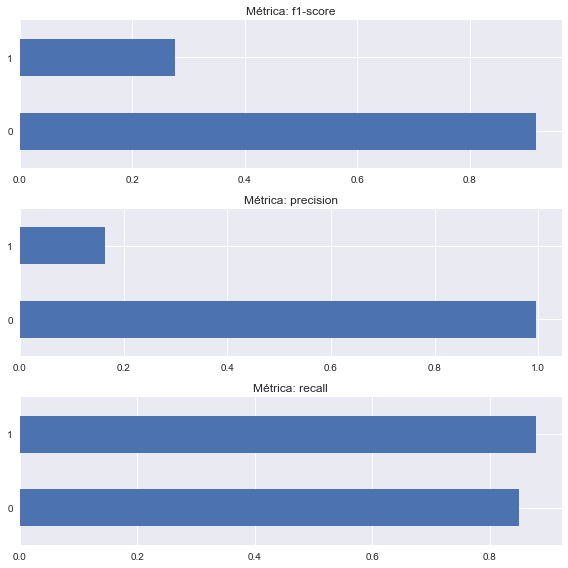

In [35]:
# Muestro las métricas de desempeño en general
print(classification_report(y_test, y_hat_oversamp))
# Muestro las métricas de desempeño por clase
plt.figure(figsize=(8, 8))
plot_class_report(y_test, y_hat_oversamp, classes_labels=df['default'].unique())

__Comentario:__ Seguimos viendo el mismo comportamiento, donde _precision_ sigue siendo bajo para los clientes morosos. Sin embargo, podemos determinar muy bien a quienes no lo son.

## Ejercicio 5: Refactorización 3 - QDA

* Por último, implemente un modelo `QuadraticDiscriminantAnalysis` con los datos aumentados artificialmente. Genere las métricas de desempeño.
* Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.

In [36]:
# implemento el modelo QDA
qda_model = QuadraticDiscriminantAnalysis().fit(X_train_oversamp, y_train_oversamp)
y_hat_qda = qda_model.predict(X_test)

Probabilidades a priori
 [0.5 0.5] 

Medias de atributos en cada clase
 [[2.900000e-01 8.044200e+02 3.347329e+04]
 [3.800000e-01 1.766970e+03 3.197242e+04]] 

Varianza explicada por cada discriminante
 [1.] 

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      3193
           1       0.16      0.88      0.28       107

    accuracy                           0.85      3300
   macro avg       0.58      0.86      0.60      3300
weighted avg       0.97      0.85      0.90      3300



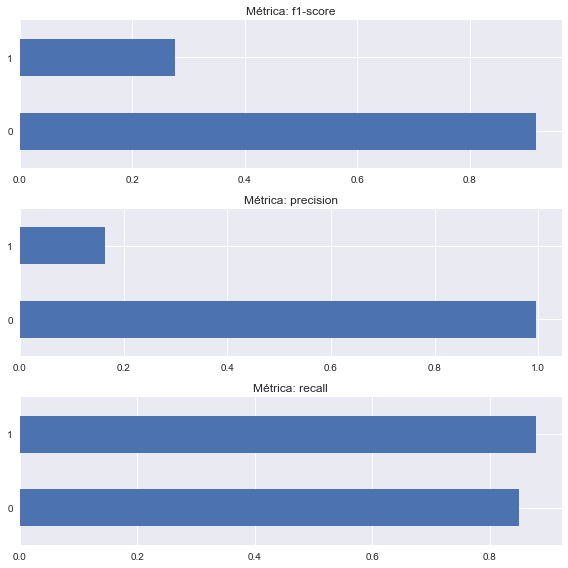

In [37]:
print("Probabilidades a priori\n", lda_model_oversamp.priors_, "\n")
print("Medias de atributos en cada clase\n", lda_model_oversamp.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n", lda_model_oversamp.explained_variance_ratio_.round(2), "\n")
# Muestro las métricas de desempeño en general
print(classification_report(y_test, y_hat_oversamp))
# Muestro las métricas de desempeño por clase
plt.figure(figsize=(8, 8))
plot_class_report(y_test, y_hat_oversamp, classes_labels=df['default'].unique())

__Comentario:__ Aún vemos el mismo desempeño. Muy bajo _precision_ respecto al primero modelo. Dado los resultados, podemos considerar al primero modelo como el mejor en la capacitdad de predecir a un cliente moroso.